Data saved successfully!


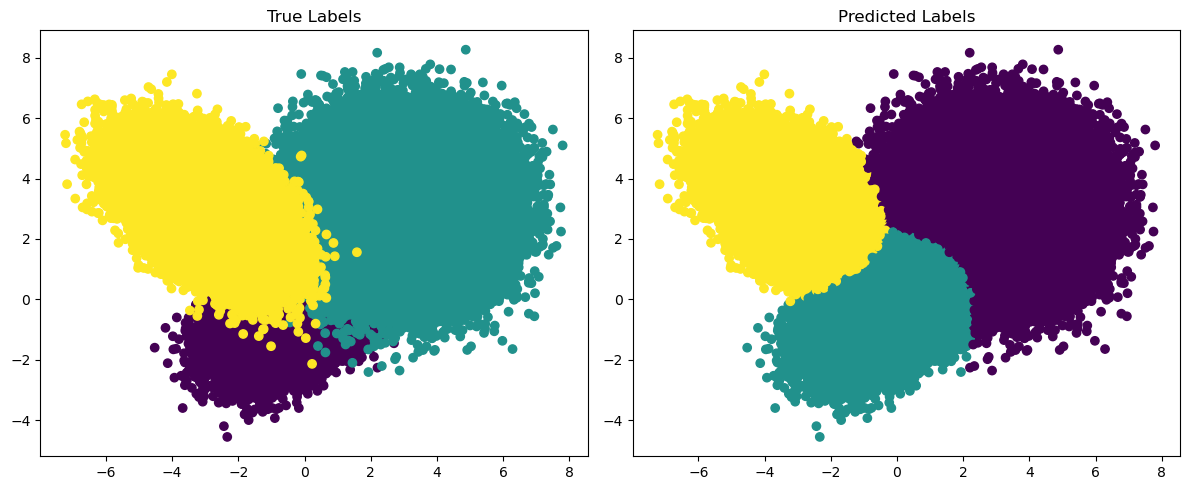

Means:
 [[ 2.99447634  2.99781147]
 [-0.00533449 -0.01116435]
 [-2.99821759  2.994324  ]]

Weights:
 [0.40038026 0.29933478 0.30028496]

Log-Likelihood: -1173566.612432508


In [101]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

class GaussianMixtureModel:
    def __init__(self, n_components=3, max_iterations=10000, 
                 tolerance=1e-4, n_init=10):
        """
        Gaussian Mixture Model with EM Algorithm
        
        Parameters:
        - n_components: Number of mixture components
        - max_iterations: Maximum EM iterations
        - tolerance: Convergence threshold
        - n_init: Number of random initializations
        """
        self.n_components = n_components
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.n_init = n_init
        
        # Model parameters
        self.weights = None
        self.means = None
        self.covariances = None
        
        # Best model tracking
        self.best_weights = None
        self.best_means = None
        self.best_covariances = None
        self.best_log_likelihood = -np.inf
        
        self.log_likelihoods = []
        self.parameter_history = {
            'means': [],
            'weights': [],
            'covariances': []
        }
        

    def random_initialization(self, X):
        """
        Randomly initialize model parameters
        """
        n_samples, n_features = X.shape
        
        # Randomly select initial means
        random_indices = np.random.choice(
            n_samples, 
            size=self.n_components, 
            replace=False
        )
        self.means = X[random_indices]
        
        # Initialize covariances
        data_cov = np.cov(X.T)
        self.covariances = [
            data_cov + np.eye(n_features) * np.random.uniform(0.1, 1.0) 
            for _ in range(self.n_components)
        ]
        
        # Uniform mixture weights
        self.weights = np.ones(self.n_components) / self.n_components
        
        return self.means, self.covariances, self.weights

    def e_step(self, X):
        """
        Expectation Step: Compute responsibilities
        """
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))
        
        # Compute responsibilities for each component
        for k in range(self.n_components):
            # Multivariate normal distribution
            mvn = multivariate_normal(
                mean=self.means[k], 
                cov=self.covariances[k]
            )
            
            # Compute weighted probability
            responsibilities[:, k] = self.weights[k] * mvn.pdf(X)
        
        # Normalize responsibilities
        row_sums = responsibilities.sum(axis=1)[:, np.newaxis]
        responsibilities /= row_sums
        
        # Compute log-likelihood
        log_likelihood = np.sum(np.log(row_sums))
        
        return responsibilities, log_likelihood

    def m_step(self, X, responsibilities):
        """
        Maximization Step: Update model parameters
        """
        n_samples, n_features = X.shape
        
        # Compute soft cluster counts
        N_k = responsibilities.sum(axis=0)
        
        # Update weights
        self.weights = N_k / n_samples
        
        # Update means
        self.means = np.dot(responsibilities.T, X) / N_k[:, np.newaxis]
        
        # Update covariances
        self.covariances = []
        for k in range(self.n_components):
            diff = X - self.means[k]
            cov = np.dot(
                (responsibilities[:, k][:, np.newaxis] * diff).T, 
                diff
            ) / N_k[k]
            
            # Add small regularization
            cov += np.eye(n_features) * 1e-6
            self.covariances.append(cov)
        
        return self.weights, self.means, self.covariances

    def fit(self, X):
        """
        Fit Gaussian Mixture Model using EM Algorithm
        """
        for init in range(self.n_init):
            # Random initialization
            self.random_initialization(X)
            
            current_log_likelihood = -np.inf
            
            # EM iterations
            for iteration in range(self.max_iterations):
                # E-step
                responsibilities, log_likelihood = self.e_step(X)
                
                # Check convergence
                if abs(log_likelihood - current_log_likelihood) < self.tolerance:
                    break
                
                current_log_likelihood = log_likelihood
                
                # M-step
                self.m_step(X, responsibilities)
                
                # Update best model if needed
                if log_likelihood > self.best_log_likelihood:
                    self.best_weights = self.weights.copy()
                    self.best_means = self.means.copy()
                    self.best_covariances = self.covariances.copy()
                    self.best_log_likelihood = log_likelihood
        
        # Set best parameters
        self.weights = self.best_weights
        self.means = self.best_means
        self.covariances = self.best_covariances
        
        return self.means, self.covariances, self.weights
    
    def fit_with_convergence_tracking(self, X):

        """

        Enhanced fit method to track convergence details

        """

        # Reset tracking lists

        self.log_likelihoods = []

        self.parameter_history = {

            'means': [],

            'weights': [],

            'covariances': []

        }

        

        for init in range(self.n_init):

            # Random initialization

            self.random_initialization(X)

            

            current_log_likelihood = -np.inf

            

            # EM iterations

            for iteration in range(self.max_iterations):

                # E-step

                responsibilities, log_likelihood = self.e_step(X)

                

                # Track log-likelihood

                self.log_likelihoods.append(log_likelihood)

                

                # Track parameter evolution

                self.parameter_history['means'].append(self.means.copy())

                self.parameter_history['weights'].append(self.weights.copy())

                self.parameter_history['covariances'].append(

                    [cov.copy() for cov in self.covariances]

                )

                

                # Check convergence

                if abs(log_likelihood - current_log_likelihood) < self.tolerance:

                    break

                

                current_log_likelihood = log_likelihood

                

                # M-step

                self.m_step(X, responsibilities)

        

        return self

    def predict(self, X):
        """
        Predict cluster assignments
        """
        responsibilities, _ = self.e_step(X)
        return np.argmax(responsibilities, axis=1)

import numpy as np
import matplotlib.pyplot as plt

def generate_synthetic_gmm_data(n_samples=3000, n_components=3):
    """
    Generate synthetic data for Gaussian Mixture Model
    
    Parameters:
    - n_samples: Total number of data points
    - n_components: Number of Gaussian distributions to mix
    
    Returns:
    - X: Generated data points
    - true_labels: True cluster assignments
    """
    
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Define means for each Gaussian component
    means = [
        [0, 0],    # Cluster 1
        [3, 3],    # Cluster 2
        [-3, 3]    # Cluster 3
    ]
    
    # Define covariance matrices for each component
    covs = [
        [[1, 0.5], [0.5, 1]],     # Covariance for Cluster 1
        [[1.5, 0], [0, 1.5]],     # Covariance for Cluster 2
        [[1, -0.5], [-0.5, 1]]    # Covariance for Cluster 3
    ]
    
    # Define mixture weights (probabilities of each component)
    weights = [0.3, 0.4, 0.3]
    
    # Prepare output arrays
    X = np.zeros((n_samples, 2))
    true_labels = np.zeros(n_samples, dtype=int)
    
    # Generate samples for each component
    for i in range(n_components):
        # Calculate number of samples for this component
        n = int(n_samples * weights[i])
        
        # Generate samples from this Gaussian
        component_samples = np.random.multivariate_normal(
            mean=means[i], 
            cov=covs[i], 
            size=n
        )
        
        # Assign to appropriate section of X
        start = sum(int(n_samples * weights[j]) for j in range(i))
        end = start + n
        X[start:end] = component_samples
        true_labels[start:end] = i
    
    return X, true_labels

# Generate data
X, true_labels = generate_synthetic_gmm_data(n_samples=300000)

# Fit GMM
gmm = GaussianMixtureModel(n_components=3, n_init=1)
means, covs, weights = gmm.fit(X)

# Predict clusters
predicted_labels = gmm.predict(X)

'''
Save the results in this format
index,predicted_cluster
0,2
1,2
2,2
3,2
'''

# Save results to CSV
import pandas as pd
results_df = pd.DataFrame({
    'index': np.arange(len(predicted_labels)),
    'predicted_cluster': predicted_labels
})

results_df.to_csv('gmm_results.csv', index=False)




# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=true_labels, cmap='viridis')
plt.title('True Labels')

plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], c=predicted_labels, cmap='viridis')
plt.title('Predicted Labels')

plt.tight_layout()
plt.show()

# Print results
print("Means:\n", means)
print("\nWeights:\n", weights)
print("\nLog-Likelihood:", gmm.best_log_likelihood)

Dataset saved successfully to datasets/gmm_data.csv and datasets/gmm_labels.csv!


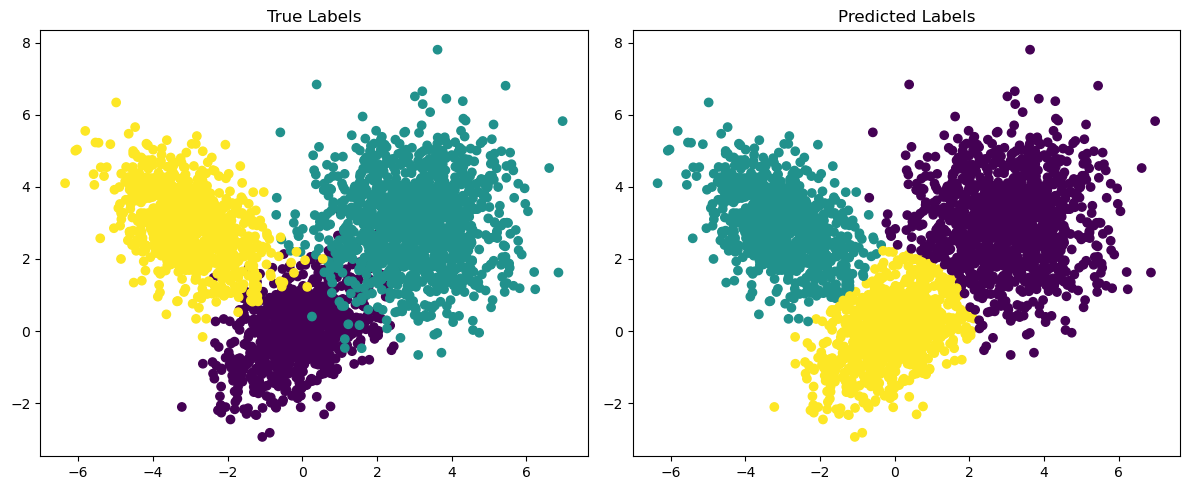

Means:
 [[ 2.97741251  2.98307006]
 [-2.96917629  2.91986322]
 [-0.06248241 -0.01783651]]

Weights:
 [0.40164109 0.30255484 0.29580408]

Log-Likelihood: -11723.002746635837


In [5]:
def save_dataset_csv(X, true_labels, prefix="gmm"):
    """
    Save generated dataset to CSV files that are easily readable in C++
    """
    import os
    import pandas as pd
    
    # Create a directory to store datasets if it doesn't exist
    os.makedirs('datasets', exist_ok=True)
    
    # Save data points to CSV
    pd.DataFrame(X, columns=['x', 'y']).to_csv(f'datasets/{prefix}_data.csv', index=False)
    
    # Save labels to CSV
    pd.DataFrame({'label': true_labels}).to_csv(f'datasets/{prefix}_labels.csv', index=False)
    
    print(f"Dataset saved successfully to datasets/{prefix}_data.csv and datasets/{prefix}_labels.csv!")

# Example usage:
X, true_labels = generate_synthetic_gmm_data(n_samples=3000)
save_dataset_csv(X, true_labels)

# Fit GMM
gmm = GaussianMixtureModel(n_components=3, n_init=1)
means, covs, weights = gmm.fit(X)

# Predict clusters
predicted_labels = gmm.predict(X)

# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=true_labels, cmap='viridis')
plt.title('True Labels')

plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], c=predicted_labels, cmap='viridis')
plt.title('Predicted Labels')

plt.tight_layout()
plt.show()

# Print results
print("Means:\n", means)
print("\nWeights:\n", weights)
print("\nLog-Likelihood:", gmm.best_log_likelihood)

Dataset saved successfully!


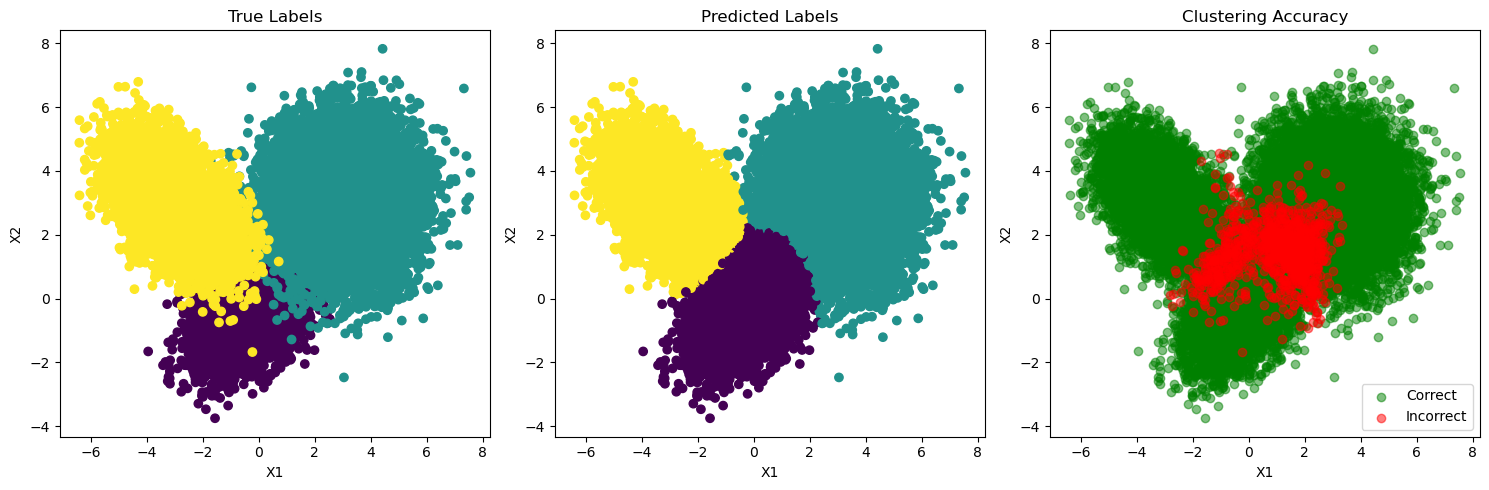


Model Parameters:
Means:
 [[-0.01431893 -0.00459112]
 [ 2.99400128  2.97883407]
 [-3.02339159  3.01402777]]

Weights:
 [0.29894218 0.4017131  0.29934472]

Log-Likelihood: -117341.43150176309

Clustering Performance Metrics:
Adjusted Rand Index: 0.8956
Normalized Mutual Information: 0.8502
Silhouette Score: 0.5499
Calinski-Harabasz Index: 55210.1880


In [95]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.metrics import (
    adjusted_rand_score,
    silhouette_score,
    calinski_harabasz_score,
    normalized_mutual_info_score
)

# (Previous GMM and data generation code remains the same)

def save_dataset(X, true_labels):
    """
    Save generated dataset to files
    """
    # Create a directory to store datasets if it doesn't exist
    import os
    os.makedirs('datasets', exist_ok=True)
    
    # Save data and labels
    np.save('datasets/gmm_data.npy', X)
    np.save('datasets/gmm_labels.npy', true_labels)
    
    print("Dataset saved successfully!")

def load_dataset():
    """
    Load previously saved dataset
    """
    X = np.load('datasets/gmm_data.npy')
    true_labels = np.load('datasets/gmm_labels.npy')
    
    return X, true_labels

def relabel_clusters(true_labels, predicted_labels):
    """
    Very fast relabeling using mapping strategy
    """
    from collections import Counter
    
    # Create a mapping of predicted to true labels
    label_mapping = {}
    
    for true_label in np.unique(true_labels):
        # Mask for current true label
        true_mask = (true_labels == true_label)
        
        # Count predicted labels in this true label region
        pred_counts = Counter(predicted_labels[true_mask])
        
        # Most common predicted label for this true label
        most_common_pred = pred_counts.most_common(1)[0][0]
        
        label_mapping[most_common_pred] = true_label
    
    # Create relabeled array
    relabeled_predicted = np.array([
        label_mapping.get(label, label) for label in predicted_labels
    ])
    
    return relabeled_predicted

def evaluate_clustering_metrics(X, true_labels, predicted_labels):
    """
    Compute comprehensive clustering performance metrics
    """
    # Relabel clusters to match true labels
    relabeled_predicted = relabel_clusters(true_labels, predicted_labels)
    
    metrics = {
        'Adjusted Rand Index': adjusted_rand_score(true_labels, relabeled_predicted),
        'Normalized Mutual Information': normalized_mutual_info_score(true_labels, relabeled_predicted),
        'Silhouette Score': silhouette_score(X, relabeled_predicted),
        'Calinski-Harabasz Index': calinski_harabasz_score(X, relabeled_predicted)
    }
    
    return metrics

def visualize_clustering(X, true_labels, predicted_labels):
    """
    Create comprehensive visualization of clustering results
    """
    # Relabel clusters
    relabeled_predicted = relabel_clusters(true_labels, predicted_labels)
    
    plt.figure(figsize=(15, 5))
    
    # Original Data with True Labels
    plt.subplot(131)
    plt.scatter(X[:, 0], X[:, 1], c=true_labels, cmap='viridis')
    plt.title('True Labels')
    plt.xlabel('X1')
    plt.ylabel('X2')
    
    # Predicted Labels
    plt.subplot(132)
    plt.scatter(X[:, 0], X[:, 1], c=relabeled_predicted, cmap='viridis')
    plt.title('Predicted Labels')
    plt.xlabel('X1')
    plt.ylabel('X2')
    
    # Comparison Plot
    plt.subplot(133)
    correct = true_labels == relabeled_predicted
    plt.scatter(X[correct, 0], X[correct, 1], c='green', label='Correct', alpha=0.5)
    plt.scatter(X[~correct, 0], X[~correct, 1], c='red', label='Incorrect', alpha=0.5)
    plt.title('Clustering Accuracy')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def main():
    # Generate and save dataset
    X, true_labels = generate_synthetic_gmm_data(n_samples=30000)
    save_dataset(X, true_labels)
    
    # Alternatively, load previously saved dataset
    # X, true_labels = load_dataset()
    
    # Fit GMM
    gmm = GaussianMixtureModel(n_components=3, n_init=1)
    means, covs, weights = gmm.fit(X)
    
    # Predict clusters
    predicted_labels = gmm.predict(X)
    
    # Visualize clustering
    visualize_clustering(X, true_labels, predicted_labels)
    
    # Evaluate clustering metrics
    metrics = evaluate_clustering_metrics(X, true_labels, predicted_labels)
    
    # Print results
    print("\nModel Parameters:")
    print("Means:\n", means)
    print("\nWeights:\n", weights)
    print("\nLog-Likelihood:", gmm.best_log_likelihood)
    
    print("\nClustering Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

if __name__ == "__main__":
    main()

In [96]:
def visualize_convergence(gmm):

    """

    Comprehensive convergence visualization

    """

    plt.figure(figsize=(15, 10))

    

    # Log-Likelihood Progression

    plt.subplot(2, 2, 1)

    plt.plot(gmm.log_likelihoods)

    plt.title('Log-Likelihood Progression')

    plt.xlabel('Iteration')

    plt.ylabel('Log-Likelihood')

    

    # Means Convergence

    plt.subplot(2, 2, 2)

    means_history = np.array(gmm.parameter_history['means'])

    for i in range(means_history.shape[1]):

        plt.plot(means_history[:, i, 0], label=f'Mean {i} - X')

        plt.plot(means_history[:, i, 1], label=f'Mean {i} - Y')

    plt.title('Means Convergence')

    plt.xlabel('Iteration')

    plt.ylabel('Mean Value')

    plt.legend()

    

    # Weights Progression

    plt.subplot(2, 2, 3)

    weights_history = np.array(gmm.parameter_history['weights'])

    for i in range(weights_history.shape[1]):

        plt.plot(weights_history[:, i], label=f'Weight {i}')

    plt.title('Mixture Weights Progression')

    plt.xlabel('Iteration')

    plt.ylabel('Weight Value')

    plt.legend()

    

    # Convergence Rate Analysis

    plt.subplot(2, 2, 4)

    log_likelihood_diff = np.diff(gmm.log_likelihoods)

    plt.plot(np.abs(log_likelihood_diff))

    plt.title('Log-Likelihood Change Rate')

    plt.xlabel('Iteration')

    plt.ylabel('|Δ Log-Likelihood|')

    

    plt.tight_layout()

    plt.show()


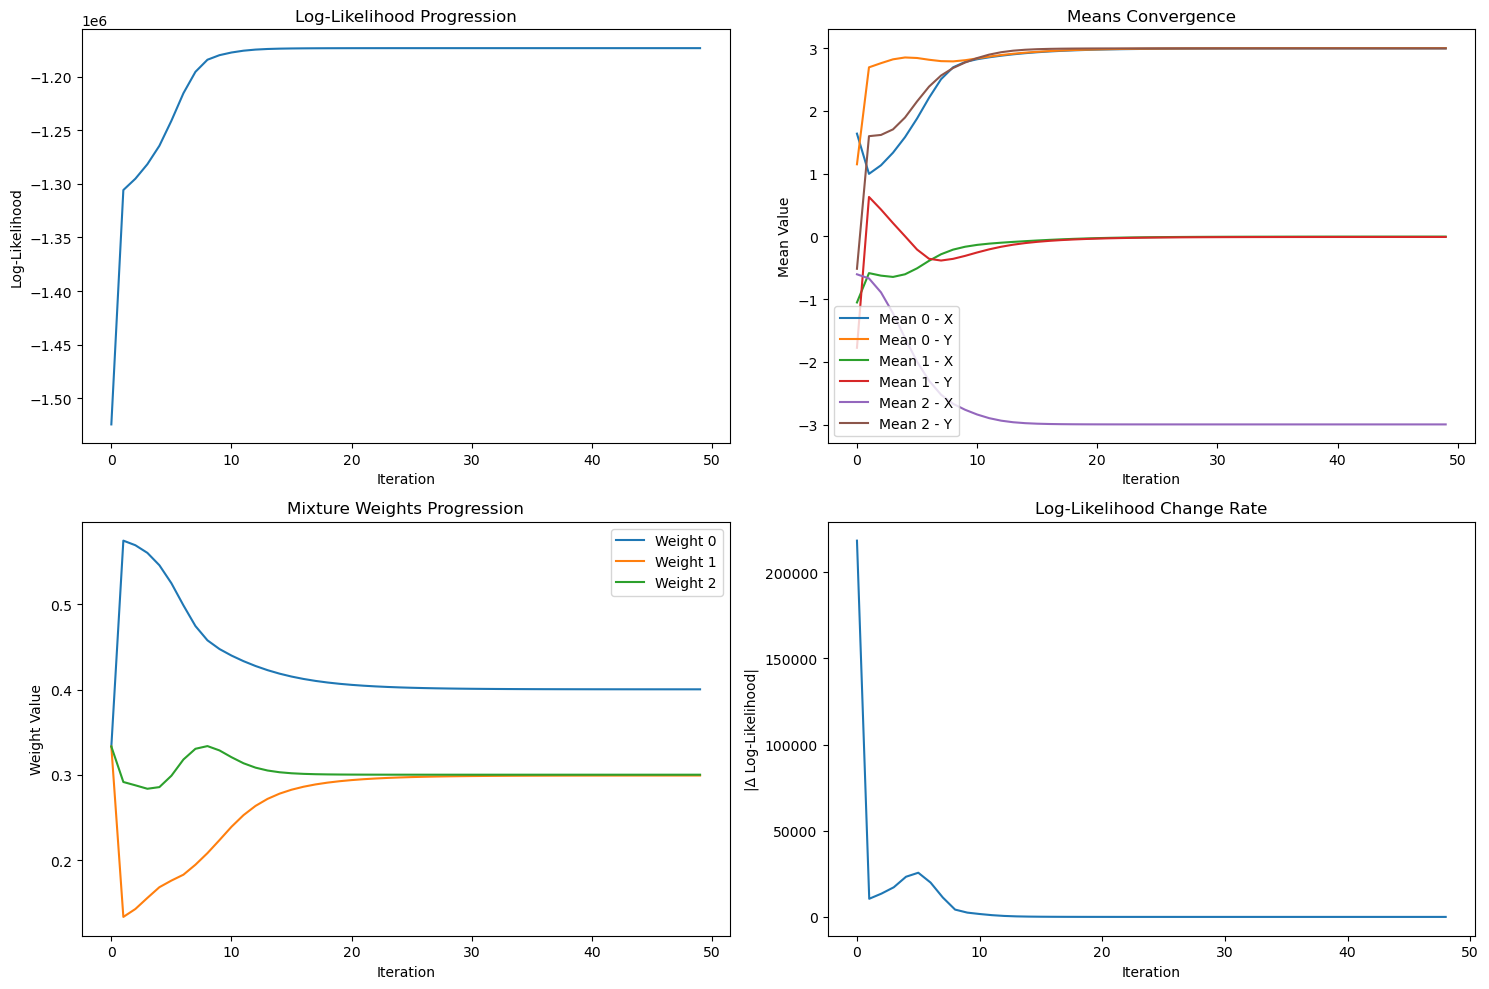

Total Iterations: 50
Final Log-Likelihood: -1173566.6123471144
Log-Likelihood Improvement: 350624.5041972501


In [100]:
 # Generate synthetic data

X, true_labels = generate_synthetic_gmm_data(n_samples=300000)



# Create GMM with convergence tracking

gmm = GaussianMixtureModel(

    n_components=3, 

    max_iterations=10000, 

    tolerance=1e-4, 

    n_init=1  # Set to 1 for clear convergence tracking

)



# Fit with convergence tracking

gmm.fit_with_convergence_tracking(X)



# Visualize convergence

visualize_convergence(gmm)



# Additional convergence insights

print("Total Iterations:", len(gmm.log_likelihoods))
print("Final Log-Likelihood:", gmm.log_likelihoods[-1])
print("Log-Likelihood Improvement:", gmm.log_likelihoods[-1] - gmm.log_likelihoods[0])